# Sleepon GO2SLEEP: Guide to data extraction and analysis

<img src="https://assets.website-files.com/5fd0c85750d2e1762f3bd544/5fd0dc3551b7336168c32913_Go2Sleep-Ring.jpeg" width="500"/>



The [Sleepon GO2SLEEP](https://www.sleepon.us/go2sleep/) is a wearable sleep tracker that stores sleep data that we will explore in this notebook.

We've used the GO2SLEEP for a while now, and we'll show you how to extract, visualize, and analyze your data! While you will need a GO2SLEEP to actually collect the data itself, the data *extraction* requires only an internet connection and your Sleepon username and password (plus a little bit of setup).

If you want to know more about the Sleepon GO2SLEEP, see [here](https://wearipedia.com/wearables/sleepon-go2sleep) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

You can extract the parameters with known sampling frequencies as below:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Heart rate (BPM)      |  1 minute
Average heart rate (BPM)      |  Every sleep session
Maximum heart rate (BPM)      |  Every sleep session
Minimum heart rate (BPM)      |  Every sleep session
Blood oxygen (SpO2 %) |  1 minute
Average blood oxygen (SpO2%)      |  Every sleep session
Maximum blood oxygen (SpO2%)      |  Every sleep session
Minimum blood oxygen (SpO2%)      |  Every sleep session
Sleep Score | Every sleep session


In this guide, we sequentially cover the following **nine** topics to extract from GO2SLEEP device:
1. **Setup**
2. **Authentication**
3. **Data extraction**
    - We get data via the participant's Sleepon login details.
4. **Data Exporting**
    - We export all of this data to file formats compatible with R, Excel, and MatLab.
5. **Adherence**
    - We simulate non-adherence by dynamically removing datapoints from our simulated data.
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced visualization**
    - 7.1: We plot a calendar heatmap of step counts every day, revealing which days the user has worn the watch.
    - 7.2: We reproduce a time series plot from the Sleepon View desktop app of heart rate, blood oxygen, and sleep scores over lifetime data.
8. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
9. **Data analysis**
    - 9.1: We test whether sleep duration and sleep scores are correlated and find a statistically significant relationship.
    - 9.2: We fit a linear regression model to the data, predicting sleep scores using sleep duration data.
    - Note that we are not making any scientific claims here as our sample size is small and the data collection process was not rigorously vetted (it is our own data), only demonstrating that this code could potentially be used to perform rigorous analyses in the future.

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own email and password on your own Colab instance, you can visualize your own *real* data. 

# 1. Setup

## Participant Setup

Dear Participant,

Once you unbox your Sleepon GO2SLEEP, please set up the device by following these resources:
- Written guide: https://sleepon-doc.oss-cn-shenzhen.aliyuncs.com/Manual/Manual-en.pdf

Make sure that your phone is paired to the device by logging in with the Sleepon login credentials (email and password) given to you by the data receiver.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Sleepon account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device and login credentials to the participant and instruct them to follow the participant setup letter above.
5. Conduct your study.
5. Receive the sleep device from participant.
6. Follow the instructions in the **Data Extraction** section to view the participant's sleep data.

In [ ]:
# Install/import necessary packages to run the notebook.

!pip install july

from datetime import *
import hashlib
import numpy as np
import pandas as pd
import pprint
from random import randrange
import requests
import scipy
from scipy import stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Authentication/Authorization

To obtain access to data, authorization is required. All you’ll need to do here is just put in your email and password for your GO2SLEEP Sleepon device. We’ll use this username and password to extract the data in the sections below.



In [ ]:
username = "parthav@stanford.edu" #@param {type:"string"}
password = "wearables" #@param {type:"string"}

# 3. Data Extraction



In [ ]:
#@title Extract data - run with simulated data if you don't have a device set up yet.

simulate_data = True #@param {type:"boolean"}

# Helper function to be used in data simulation.
def scale_down(x, max, min):
  return int(((100*(x - min))/(max-min)))

# Request actual data if user set simulate_data to false.
if not simulate_data:
  # Hash password for API request
  hashed_password = hashlib.sha1(password.encode('ASCII')).hexdigest()

  # URL to make GET request for token
  get_token_url = ('https://en.sleepon.us/api/User/login?type=2&'
                    'password='+hashed_password+
                    '&loginname='+username)

  # Make a GET request to the URL
  response = requests.get(get_token_url)
  # Extract payload dict from response json
  payload_dict = response.json()
  # Print initial response
  print(payload_dict)
  # Extract token from payload dict
  token = payload_dict["token"]

  # URL to make GET request for data
  get_data_url = ('https://en.sleepon.us/api/Sleep/getDataV1?'
                  'sleep_device_num=Go2Sleep'
                  '&token='+token #API token
                  )

  # Make a GET request to the URL
  response = requests.get(get_data_url)  
  # Print status code (and associated text)
  print(f"Request returned {response.status_code} : '{response.reason}'")
  # Print data returned (parsing as JSON)
  payload = response.json()  
  # Print retrieved data - uncomment to view actual payload
  # pp = pprint.PrettyPrinter(indent=1)
  # pp.pprint(payload)
  # Store retrieved data as a Pandas dataframe.
  sleep_data = payload['data']['sleep']
  sleep_df = pd.DataFrame.from_dict(sleep_data)
# Otherwise, simulate dataframe:
else:
  # List of simulated data types
  columns = ['ss_time', 'ss_start_time', 'ss_end_time', 'ss_score', 'ss_heart_raw', 'ss_heart_avg', 'ss_heart_max', 'ss_heart_min', 'ss_spo2_raw', 'ss_spo2_avg', 'ss_spo2_max', 'ss_spo2_min']

  # Create empty dataframe
  sleep_data = pd.DataFrame()

  # Generate 1 year of past dates for ss_time column:
  sleep_data['ss_time']= pd.date_range(date.today() - timedelta(days=365), periods=365)

  # Generate ss_start_time and ss_end_time
  sleep_data['ss_start_time'] = [(date + timedelta(hours=22) + timedelta(minutes=randrange(120))) for date in sleep_data['ss_time']]
  sleep_data['ss_end_time'] = [(date + timedelta(hours=30) + timedelta(minutes=randrange(120))) for date in sleep_data['ss_time']]

  # Generate ss_score based on sleep duration (NOTE: creating artifical relationship for later analysis)
  durations = (sleep_data['ss_end_time'] - sleep_data['ss_start_time'])
  sleep_length = [x.total_seconds() for x in durations]
  length_max, length_min = max(sleep_length), min(sleep_length)
  sleep_data['ss_score'] = [scale_down(x, length_max, length_min) + abs(scipy.stats.norm.rvs(loc=10,scale=5)) for x in sleep_length]
  #sleep_data['ss_score'] = [int(score) if 0 <= score <= 100 else 100 if score > 100 else 0 for score in np.random.normal(loc=80, scale=10, size=len(sleep_data))]

  # Generate heart rate data
  # Randomly generate means
  sleep_data['ss_heart_avg'] = [randrange(50, 65) for i in range(len(sleep_data))]
  # Generate minute-by-minute heart rate data from normal distribution with chosen mean 
  ss_heart_raw = []
  time_diff = sleep_data['ss_end_time'] - sleep_data['ss_start_time']
  num_mins = [int(diff.total_seconds()/60) for diff in time_diff]
  for i in range(len(sleep_data)):
    raw_rates = [rate if 30 < rate <= 110 else 110 - randrange(5) if rate > 110 else 30 + randrange(5) for rate in np.random.normal(loc=sleep_data['ss_heart_avg'][i], scale=10, size=num_mins[i]).astype(int)]
    ss_heart_raw.append(raw_rates)
  sleep_data['ss_heart_raw'] = np.asarray(ss_heart_raw,dtype=object)
  sleep_data['ss_heart_max'] = [max(rates) for rates in sleep_data['ss_heart_raw']]
  sleep_data['ss_heart_min'] = [min(rates) for rates in sleep_data['ss_heart_raw']]

  #Generate SpO2 data
  # Randomly generate means
  sleep_data['ss_spo2_avg'] = [randrange(90, 99) for i in range(len(sleep_data))]
  # Generate minute-by-minute SpO2 data from normal distribution with chosen mean 
  ss_spo2_raw = []
  time_diff = sleep_data['ss_end_time'] - sleep_data['ss_start_time']
  num_mins = [int(diff.total_seconds()/60) for diff in time_diff]
  for i in range(len(sleep_data)):
    raw_rates = [rate if 89 <= rate <= 99 else 99 - randrange(2) if rate > 99 else 89 + randrange(3) for rate in np.random.normal(loc=sleep_data['ss_spo2_avg'][i], scale=1, size=num_mins[i]).astype(int)]
    ss_spo2_raw.append(raw_rates)
  sleep_data['ss_spo2_raw'] = np.asarray(ss_spo2_raw,dtype=object)
  sleep_data['ss_spo2_max'] = [max(rates) for rates in sleep_data['ss_spo2_raw']]
  sleep_data['ss_spo2_min'] = [min(rates) for rates in sleep_data['ss_spo2_raw']]
  sleep_df = sleep_data
  print("Generated simulated data.")


Generated simulated data.


In [ ]:
# Run this cell to view the dataframe.
sleep_df

# 4. Data Exporting

In this section, we export all of this data to be compatible with popular scientific computing software (R, Excel, Google Sheets, Matlab). By default, our data is in a Pandas dataframe. Here, we will export to CSV, which can be consumed by R, Excel, Google Sheets, and every other popular programming language.

Feel free to open the file viewer (see left pane) to look at the outputs!

## Exporting to CSV and XLSX (Excel, Google Sheets, R, Matlab, etc.)

This code exports all the sleep data on your device and stores it in one .csv file (visible in the file viewer). This .csv file replicates the one available by manually downloading monthly data from the Sleepon app - except it writes data from ALL your sleep sessions into one .csv file! This saves a lot of time.

In [ ]:
import csv

# If we didn't simulate the data, convert from JSON to CSV.
if not simulate_data:
  #Get sleep data from payload JSON
  sleep_data = payload['data']['sleep']

  with open('sleep_data.csv', 'w') as csvfile:
    # Get column names
    field_names = sleep_data[0].keys()
    # Write all sleep data to csv file
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(sleep_data)
# Otherwise, convert from Pandas dataframe to CSV.
else:
  sleep_df.to_csv('sleep_data.csv')


Again, feel free to look at the output files and download them.

# 5. Adherence

Non-adherence refers to sleep periods during the study where the GO2SLEEP device is not worn. In this section, we will simulate non-adherence over periods of time.

Then, we will detect this non-adherence and give a Pandas DataFrame that concisely describes when the participant has had their device on and off throughout the entirety of the time period, allowing you to calculate how long they've had it on/off etc.

We will first delete a certain % of blocks either at the day level or week level, with user input.

In [ ]:
#@title Non-adherence simulation
import numpy as np

adherence_percent = 0.63 #@param {type:"slider", min:0, max:1, step:0.01}


num_blocks = len(sleep_df)

num_blocks_to_keep = int(adherence_percent * num_blocks)

idxes = np.random.choice(np.arange(num_blocks), replace=False, size=num_blocks_to_keep)
idxes.sort()
adhered_df = sleep_df.loc[idxes]
len(adhered_df)

197

And now we have significantly fewer datapoints! This will give us a more realistic situation, where participants may take off their device for days or weeks at a time.

Now let's detect non-adherence. We will return a Pandas DataFrame sampled daily that indicates if the wearable was being worn that day or not.

In [ ]:
comparison_df = pd.DataFrame()
comparison_df['ss_time'] = pd.date_range(start=sleep_df.loc[0]['ss_time'], end=sleep_df.loc[len(sleep_df)-1]['ss_time']) 
comparison_df['is_wearing'] = comparison_df['ss_time'].isin(adhered_df['ss_time'])
comparison_df.head()

,ss_time,is_wearing
0,2022-02-21,False
1,2022-02-22,True
2,2022-02-23,False
3,2022-02-24,False
4,2022-02-25,True


We can plot this out, and we get adherence at a daily interval throughout the entirety of the data collection period. Blue bars indicate days the wearable was worn, and whitespace indicates days it was not worn.

(0.0, 1.0)

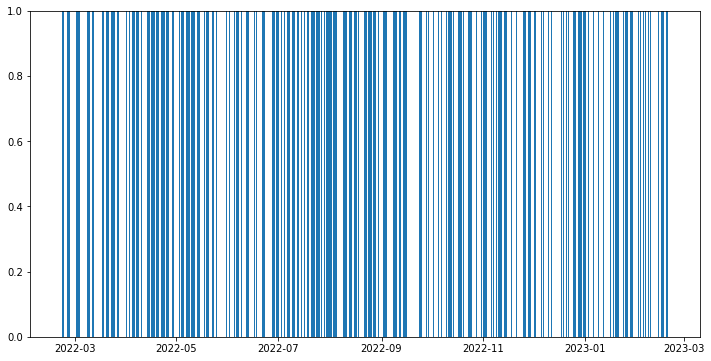

In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta

plt.figure(figsize=(12, 6))
plt.bar(x=comparison_df['ss_time'], height=comparison_df['is_wearing'])
plt.ylim([0, 1])

## 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

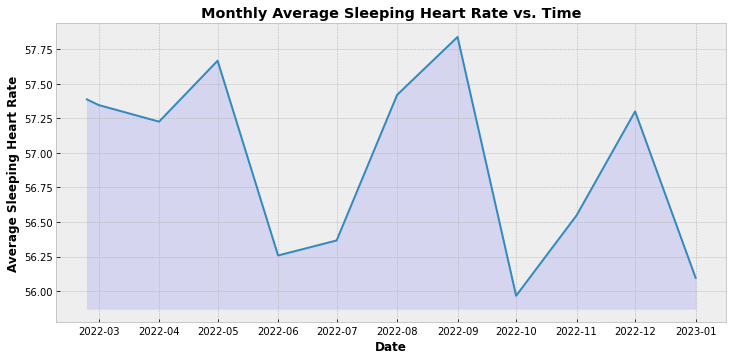

In [ ]:
#@title Basic Plot
feature = "ss_heart_avg" #@param ["ss_heart_avg", "ss_spo2_avg"]
start_date = "2022-02-23" #@param {type:"date"}
time_interval = "Monthly" #@param ["Daily", "Monthly"]

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import runtime

valid_start = sleep_df['ss_time'][0]
valid_end = sleep_df['ss_time'][len(sleep_df) - 1]



start_date = datetime.strptime(start_date, '%Y-%m-%d')

if not (valid_start <= start_date <= valid_end):
  print("Please enter a date in the range " + str(valid_start) + " to " + str(valid_end))


plt.rcParams["figure.figsize"] = (12,5.5)

df = sleep_df.loc[sleep_data['ss_time'] >= start_date]

if time_interval == "Daily":
  y_data = df[feature]
  x_data = df['ss_time']
else:
  y_data = df.groupby(df.ss_time.dt.month)[feature].mean()
  x_data = df.groupby(df.ss_time.dt.month)['ss_time'].min()
  x_data = pd.to_datetime(x_data, format="%Y-%m-%d %H:%M:%S.%f").sort_values()

if feature == "ss_heart_avg":
  ylabel = 'Average Sleeping Heart Rate'
else:
  ylabel = 'Average Sleeping Blood Oxygen %'

xlabel = 'Date'
data = pd.DataFrame({xlabel: x_data, ylabel: y_data})

with plt.style.context('bmh'):
  plt.plot(x_data, y_data)
  plt.xlabel('Date', fontweight='bold')
  plt.ylabel(ylabel, fontweight='bold')
  plt.title(time_interval+" "+ylabel+ " vs. Time", fontweight='bold')
  plt.fill_between(x_data, y_data, y2=plt.gca().get_ylim()[0], color='blue', alpha=0.1)
  plt.show()




This plot allows you to quickly scan your data at different time scales (daily vs. monthly) and for different kinds of measurements (heart rate or blood oxygen level), which enables easy and fast data exploration.

# 7. Advanced Visualization

Now we'll do some more advanced plotting that has the benefit of aesthetic quality.

## 7.1. Calendar plot of usage/sleep score over time

As an example, we will make a calendar plot of the data showing sleep scores. This will allow us to quickly identify periods of time with 'good sleep' vs. periods of time with 'bad sleep.' This gives us some insight into sleep quality at different times.

Fortunately, a calendar plot is easy to execute with the use of [`july`](https://github.com/e-hulten/july/), a custom library that allows us to create beautiful calendar plots.

Note that the timestamps of each GO2SLEEP measurement correspond to days demarcated by midnight *not necessarily in UTC*, but rather the timezone where the user lives. 

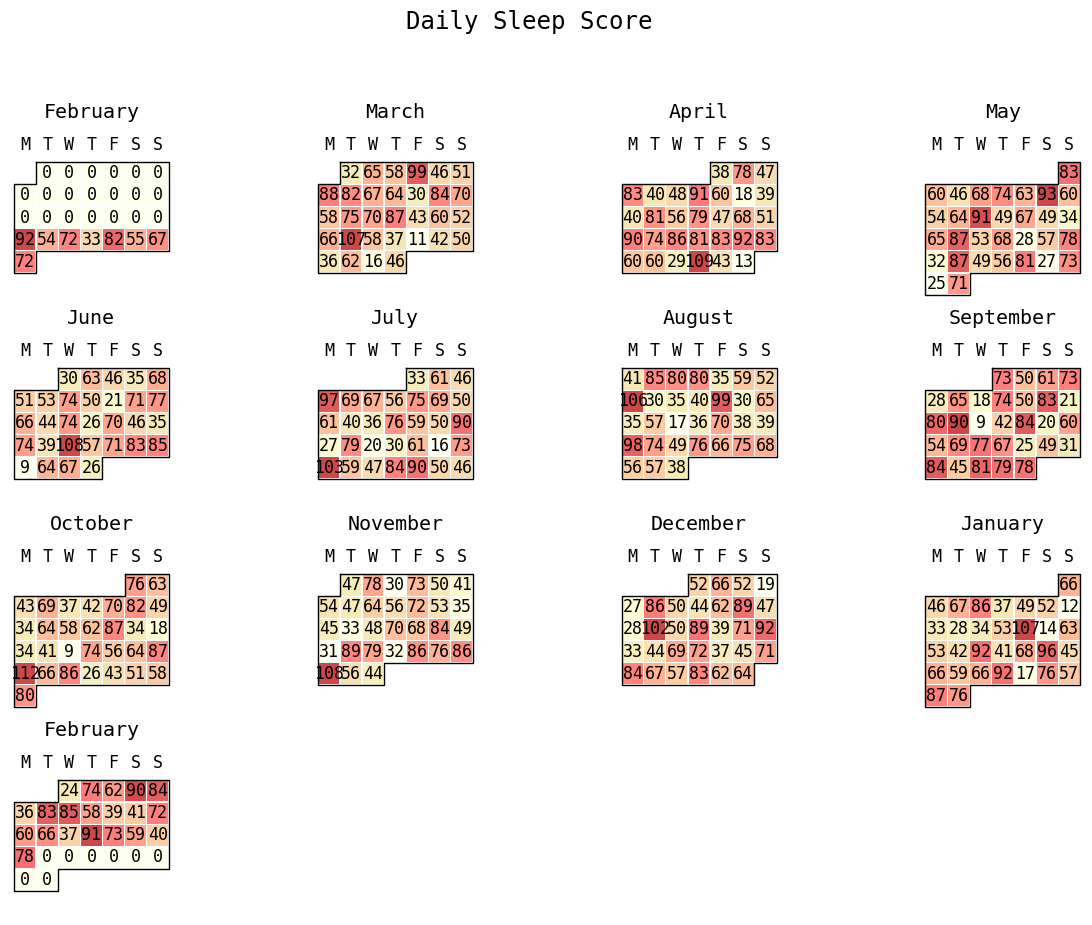

In [ ]:
# sum across hour axis
import july
import matplotlib.pyplot as plt

# copy so we can restore the rcParams later on; july changes it
IPython_default = plt.rcParams.copy()

july.calendar_plot(sleep_df['ss_time'], sleep_df['ss_score'], value_label=True, weeknum_label=False, title=False)
plt.suptitle('Daily Sleep Score', fontsize="x-large", y=1.03)
plt.show()  # suppress output from above line

## 7.2 Interactive and customizable plot of GO2SLEEP metrics

Next, we try and replicate some of the in-built plots that Sleepon provides in their products.

The below plot is available upon uploading .csv data downloaded from the Sleepon app (or generated using our notebook!) to the Sleepon View desktop app. The Sleepon View desktop app is a free companion app that Sleepon offers, allowing you to visualize exported data on your computer.

Here, we will demonstrate some advanced visualization by making a similar plot of our simulated data, on the metrics heart rate, blood oxygen, and sleep score.


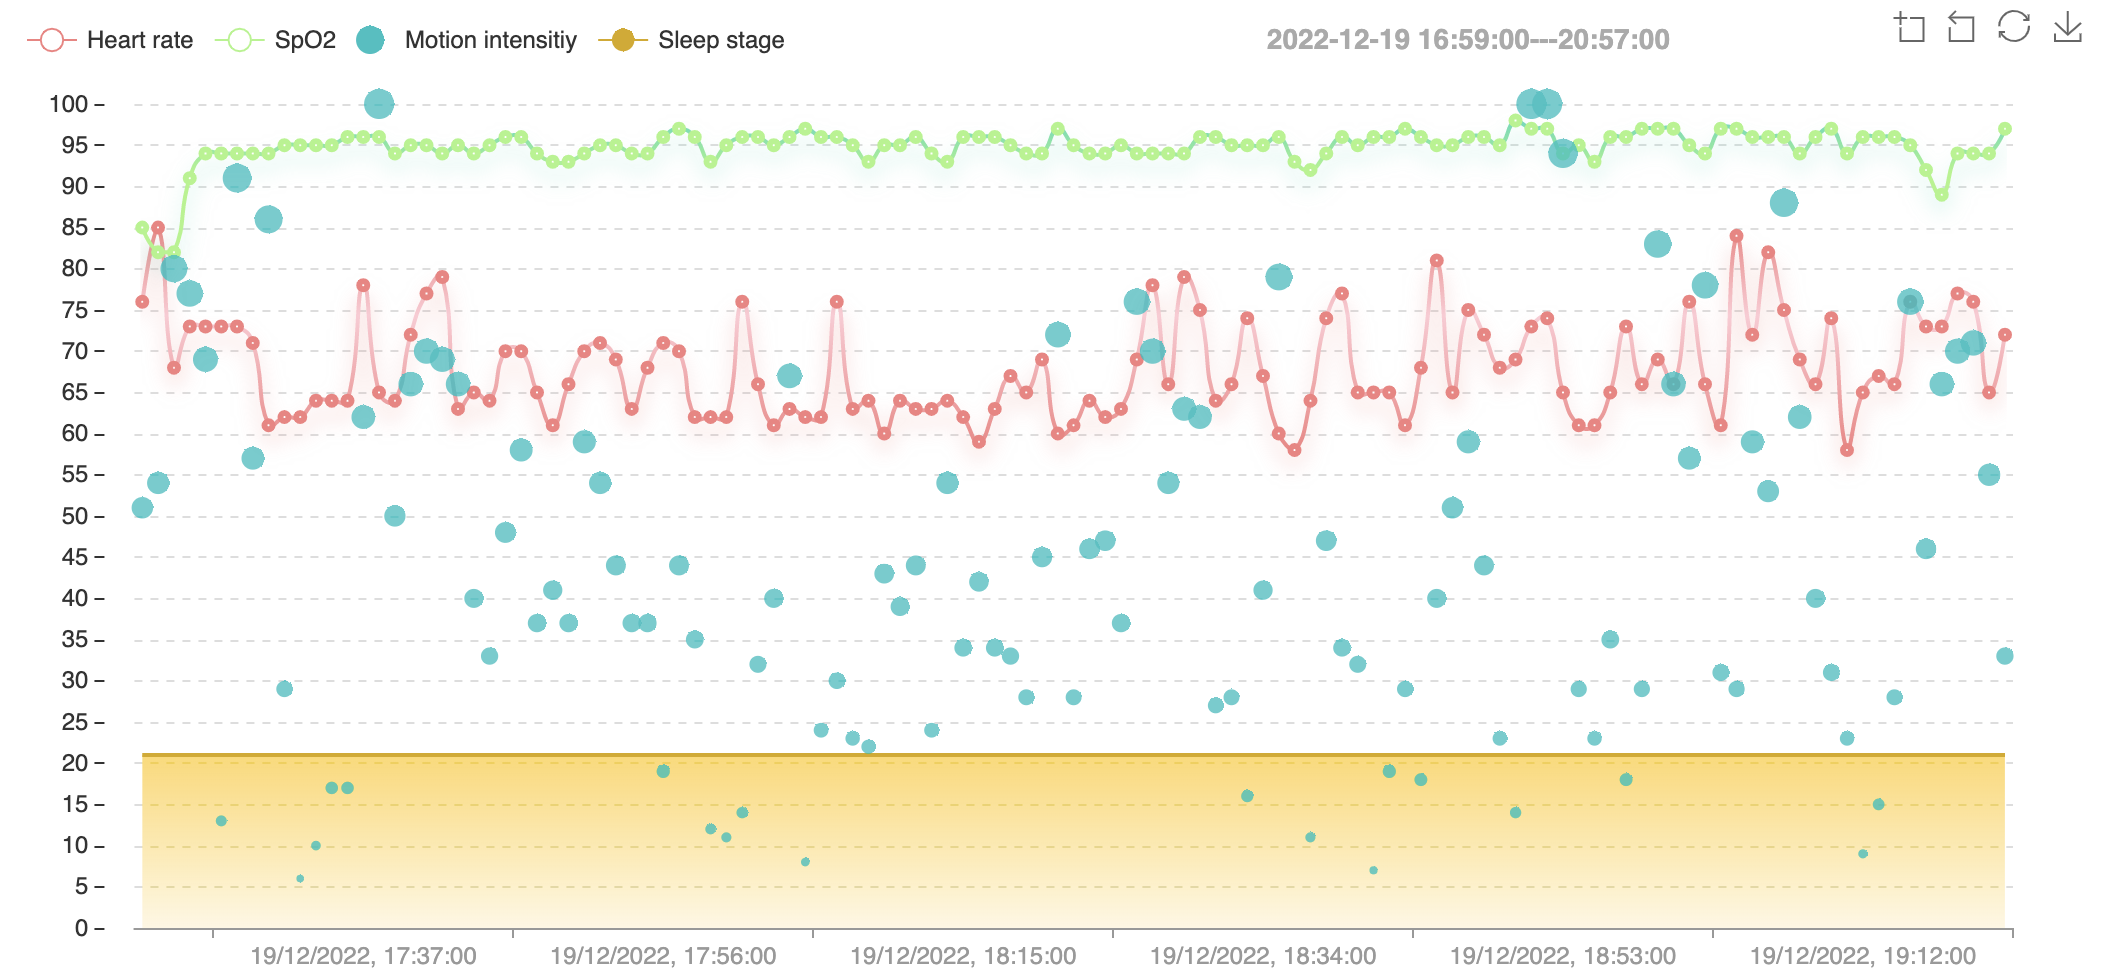


The below graph allows you to hover over points to view their values. The sleep score markers are sized based on the magnitude of sleep score. The time period displayed is adjustable, and any combination of the three variables can be displayed. This plot is intended to demonstrate the flexibility of visualization that can be achieved in Python.

In [ ]:
# get rid of any garbage output
# https://stackoverflow.com/questions/56727370/how-to-suppress-output-in-google-colaboratory-cell-which-executes-a-command-line
#%%capture

import numpy as np
import pandas as pd
from datetime import date, timedelta
import plotly.express as px
import plotly.graph_objects as go


#@title Interactive Plot Demonstration
period = "Previous 30 Days" #@param ["Previous 30 Days", "Previous 180 Days"]
include_heart_avg = True #@param {type:"boolean"}
include_spo2_avg = True #@param {type:"boolean"}
include_sleep_score = True #@param {type:"boolean"}


fig = go.Figure()

# Subset data for desired time period
if period == "Previous 30 Days":
  today = date.today()
  initial_date = today - timedelta(days=30)
  initial_as_datetime = datetime(initial_date.year, initial_date.month, initial_date.day)
  data = sleep_df.loc[sleep_df['ss_time'] >= initial_as_datetime]
  fig.update_xaxes(
    dtick=24*60*60*1000,
    tickformat="%d\n%b")
else:
  today = date.today()
  initial_date = today - timedelta(days=180)
  initial_as_datetime = datetime(initial_date.year, initial_date.month, initial_date.day)
  data = sleep_df.loc[sleep_df['ss_time'] >= initial_as_datetime]
  fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

x = data['ss_time']

if (include_heart_avg):
  y_hr = data['ss_heart_avg']
  fig.add_trace(go.Scatter(x=x, y=y_hr, name="Avg. Heart Rate", line_color='red',
                      hoverinfo='name+y',
                      line_shape='spline',
                      mode='lines+markers',
                      marker=dict(color='red')))

if (include_spo2_avg):
  y_spo2 = data['ss_spo2_avg']
  fig.add_trace(go.Scatter(x=x, y=y_spo2, name="Avg. SpO2 %",
                      text=["tweak line smoothness<br>with 'smoothing' in line object"],
                      hoverinfo='name+y',
                      line_shape='spline',
                      mode='lines+markers',
                      marker=dict(color='limegreen')))
  
if (include_sleep_score):
  y_score = data['ss_score']
  fig.add_trace(go.Scatter(x=x, y=y_score, 
                          name='Sleep Score', 
                          hoverinfo = 'name+y',
                          mode='markers',
                          marker_size=y_score/5,
                          marker=dict(color='teal')))

fig.update_layout(yaxis = dict(tickmode = 'linear',
                               tick0 = 0,
                               dtick = 5))

start = str((x.iloc[0]).date())
end = str((x.iloc[-1]).date())
fig.update_layout(title_text="Plotting data from "+start+" to "+end)

fig.show()




# 8. Outlier Detection and Data Cleaning

In this section, we will detect outliers in our extracted data and impute them.

Outliers can occur in datasets as a result of external circumstancesor even random chance. Regardless, removing them from the dataset *can* be important, as their inclusion can change the results of our analysis and/or any models trained on our data.

That said, it is important to note that different definitions of 'outlier' may lead us to remove different values from our dataset. It is up to the researcher to decide whether the datapoints identified are outliers that need to be removed, or merely extreme values that are part of the phenomenon being measured. 

With this in mind, this section will go through detecting outliers using two different methods for outlier detection: Inter-Quartile Range and Z-Score.

For the sake of this example, we will focus on removing outliers in the nightly heart rate data and blood oxygen data, operating under the assumption that there may be one-off inaccuracies in the minute-by-minute measurements made by the GO2SLEEP device.

In [ ]:
# This function finds outliers in a list based on the given method (IQR or Z-Score) and replaces them with the mean of the dataset.
def find_outliers(data, method):
  data = np.asarray(data)
  mean = data.mean()
  outliers_found = False
  if method == 'iqr':
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1
    lower_limit = q1 - (1.5 * iqr)
    upper_limit = q3 + (1.5 * iqr)
    outliers = data[(data > upper_limit) | (data < lower_limit)]
    if len(outliers) > 0: outliers_found=True
    data[(data > upper_limit) | (data < lower_limit)] = mean
  elif method == 'z':
    import scipy.stats as stats
    # Using Z-Score = 3 as the cutoff for an outlier
    outliers = data[(stats.zscore(data) > 3) | (stats.zscore(data) < -3)]
    if len(outliers) > 0: outliers_found=True
    data[(stats.zscore(data) > 3) | (stats.zscore(data) < -3)] = mean 
  return outliers_found, list(data)


In [ ]:
#@title Heart rate outlier detection based on Inter-Quartile Range (IQR) 
total = 0
for i, measurements in enumerate(sleep_df['ss_heart_raw']):
  outliers_found, sleep_df['ss_heart_raw'].loc[i] = find_outliers(measurements, 'iqr')
  print("Outliers found on "+str(sleep_df['ss_time'].loc[i]) + ": "+str(outliers_found))
  total += int(outliers_found)
print("Total number of days with outliers: "+str(total))


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Outliers found on 2022-02-21 00:00:00: True
Outliers found on 2022-02-22 00:00:00: True
Outliers found on 2022-02-23 00:00:00: True
Outliers found on 2022-02-24 00:00:00: True
Outliers found on 2022-02-25 00:00:00: False
Outliers found on 2022-02-26 00:00:00: True
Outliers found on 2022-02-27 00:00:00: True
Outliers found on 2022-02-28 00:00:00: True
Outliers found on 2022-03-01 00:00:00: True
Outliers found on 2022-03-02 00:00:00: False
Outliers found on 2022-03-03 00:00:00: True
Outliers found on 2022-03-04 00:00:00: False
Outliers found on 2022-03-05 00:00:00: True
Outliers found on 2022-03-06 00:00:00: True
Outliers found on 2022-03-07 00:00:00: False
Outliers found on 2022-03-08 00:00:00: True
Outliers found on 2022-03-09 00:00:00: True
Outliers found on 2022-03-10 00:00:00: True
Outliers found on 2022-03-11 00:00:00: False
Outliers found on 2022-03-12 00:00:00: False
Outliers found on 2022-03-13 00:00:00: True
Outliers found on 2022-03-14 00:00:00: True
Outliers found on 2022-03-

In [ ]:
#@title Heart rate outlier detection based on Z-Score
total = 0
for i, measurements in enumerate(sleep_df['ss_heart_raw']):
  outliers_found, sleep_df['ss_heart_raw'].loc[i] = find_outliers(measurements, 'z')
  print("Outliers found on "+str(sleep_df['ss_time'].loc[i]) + ": "+str(outliers_found))
  total += int(outliers_found)
print("Total number of days with outliers: "+str(total))


Outliers found on 2022-02-21 00:00:00: False
Outliers found on 2022-02-22 00:00:00: False
Outliers found on 2022-02-23 00:00:00: False
Outliers found on 2022-02-24 00:00:00: False
Outliers found on 2022-02-25 00:00:00: False
Outliers found on 2022-02-26 00:00:00: False
Outliers found on 2022-02-27 00:00:00: False
Outliers found on 2022-02-28 00:00:00: False
Outliers found on 2022-03-01 00:00:00: False
Outliers found on 2022-03-02 00:00:00: False
Outliers found on 2022-03-03 00:00:00: False
Outliers found on 2022-03-04 00:00:00: False
Outliers found on 2022-03-05 00:00:00: False
Outliers found on 2022-03-06 00:00:00: False
Outliers found on 2022-03-07 00:00:00: False
Outliers found on 2022-03-08 00:00:00: False
Outliers found on 2022-03-09 00:00:00: False
Outliers found on 2022-03-10 00:00:00: False
Outliers found on 2022-03-11 00:00:00: False
Outliers found on 2022-03-12 00:00:00: False
Outliers found on 2022-03-13 00:00:00: False
Outliers found on 2022-03-14 00:00:00: False
Outliers f

And we have properly cleaned up this data of outliers!

Disclaimer: In your specific situation there may be outliers this does not catch. Adjust your outlier tolerance accordingly.

# 9. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section. The below analysis is conducted entirely on simulated data, so please see the DISCLAIMER below regarding results. The primary purpose of this section is to demonstrate code that can be used to conduct data analysis.

DISCLAIMER: Do not use the analyses below as evidence supporting any scientific claims. These analyses are purely intended for educational purposes.


## 9.1 Sleep duration vs. sleep score

Here, we will test our data to see whether the length of a sleep session is correlated with the session's sleep score. This will give us some insight into whether more sleep is necessarily good sleep.

First, to get an intuitive understanding of the data, we can plot a scatterplot of sleep duration (in seconds) against sleep scores.

DISCLAIMER: The simulated data (by construction) creates a relationship between sleep score and sleep duration. This data is not based on empirical measurements.

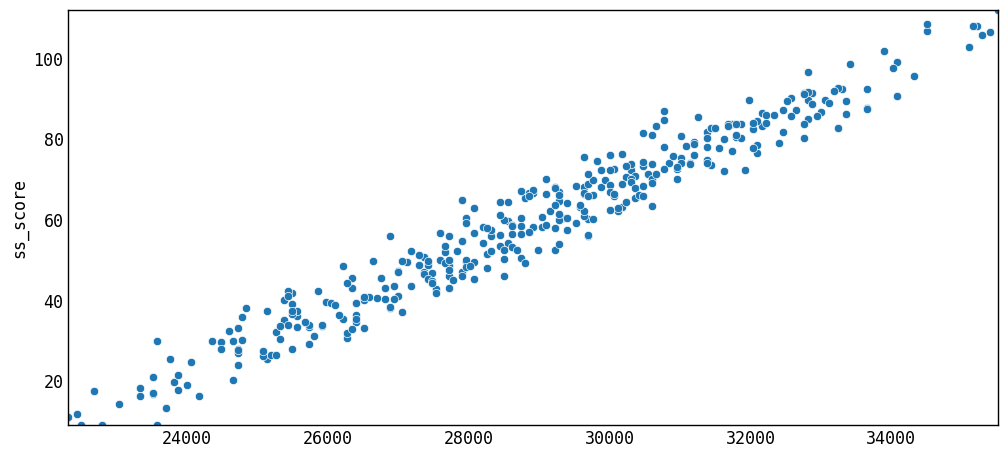

In [ ]:
import seaborn as sns

durations = (sleep_data['ss_end_time'] - sleep_data['ss_start_time'])
sleep_length = [x.total_seconds() for x in durations]
sns.scatterplot(x=sleep_length, y=sleep_df['ss_score'])

As expected, there is a strong trend here - it appears that longer sleep durations imply better sleep scores. However, let us analyze this more rigorously. To provide strong quantitative evidence in favor of our claim, we look at two things. 

First, we calculate the Pearson Correlation Coefficient, which is a normalized measure of how much two random variables co-vary. A correlation coefficient close to +/- 1 indicates a strong correlation, while a correlation close to 0 indicates no correlation.

In [ ]:
from scipy import stats

corr, _ = stats.pearsonr(sleep_df['ss_score'], sleep_length)
corr

0.9760986354017219

As we can see, the correlation is close to 1, which indicates a strong correlation (strong positive linear relationship) between sleep duration and sleep length in our dataset. Just to reiterate: This is to be expected given our construction of sleep scores.

Now, we assess the null hypothesis via regression analysis. The null hypothesis is the statement that sleep duration is not associated with better sleep scores. More formally, we test the hypothesis that the regression coefficient of sleep length in our regression model is equal to 0. To test this, we can calculate the probability that this observed relationship occurred due to random chance. This probability is known as the p-value. 


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(sleep_df['ss_score'], sleep_length)
print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Slope: 127
Coefficient of determination: 0.953
p-value: 1.01e-242


The above p-value is far, far smaller than our alpha threshold of 0.05. This indicates that the relationship is statistically significant, and we can conclude that the null hypothesis is false. Therefore, the correlation between sleep duration and sleep score is statistically significant.

Of course, this p-value is incredibly small due to our construction of the simulated data. Such a small value would not occur with real data, but the same procedure for analysis can be followed.

## 9.2 Predicting sleep score using sleep duration through linear regression

As a final experiment, we are going to see if we can build a simple linear model fit using least squares regression to predict sleep score based on the sleep duration. 

From the value of the slope/correlation coefficient (calculated above), we can see that there is a strong linear relationship between these two variables. Hence, a linear regression will likely be a suitable class of model to apply to this data.

In [ ]:
# Create response and predictor vectors
x = sleep_length
y = sleep_df['ss_score']

# Training/test data split:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=101)

# Fit least squares regression and print summary:
import statsmodels.api as sm
x_train_Sm = sm.add_constant(x_train)
ls = sm.OLS(y_train,x_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:               ss_score   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     4681.
Date:                Tue, 21 Feb 2023   Prob (F-statistic):          7.60e-149
Time:                        01:27:46   Log-Likelihood:                -645.68
No. Observations:                 219   AIC:                             1295.
Df Residuals:                     217   BIC:                             1302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -161.1619      3.242    -49.713      0.0

Above, we have fit a linear regression to the data. Now, we begin to evaluate the 'goodness of fit.'

In order to do this, we can look at the R-squared value in the top right of the table. An R-squared value of close to 1 is an indication that most of the variance in the data is explained by our model - i.e., our model fits the data well.

In general, R-squared ranges from 0 to 1: 0 implies a poor linear fit, while 1 implies a perfect fit. 

We can look also look at adjusted R-squared to look at how the model performs. Adjusted R-squared is the same as R-squared, but adjusts for the number of covariates in our regression. Since we have only one covariate in our regression (sleep duration), the adjusted R-squared is the same as the R-squared value.

Now, we move on to make predictions on our data:

In [ ]:
x_test_Sm = sm.add_constant(x_test)
y_pred = ls.predict(x_test_Sm)

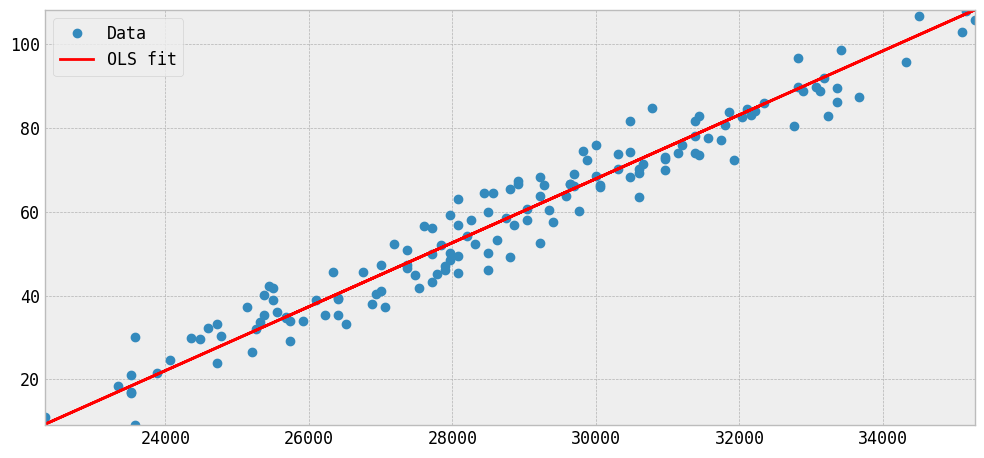

In [ ]:
with plt.style.context('bmh'):
  fig, ax = plt.subplots()
  ax.plot(x_test, y_test, "o", label="Data")
  ax.plot(x_test, y_pred, "r", label="OLS fit")
  ax.legend(loc="best")

From above, it appears that our linear regression model fits the data quite well. To calculate a point estimate of just how well the model fits, we can also calculate the test mean squared error of our model:

In [ ]:
mse = ((y_test - y_pred)**2).mean()
print(mse)

25.045133937915544


Finally, we can validate the linear regression assumption that the errors are normally distributed, in order to ensure that our results constitute a valid regression. To do so, we can plot the residuals.

From below, it is apparent that the residuals (errors) of our model's predictions roughly follow a normal distribution, so the linear regression assumption appears reasonable.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



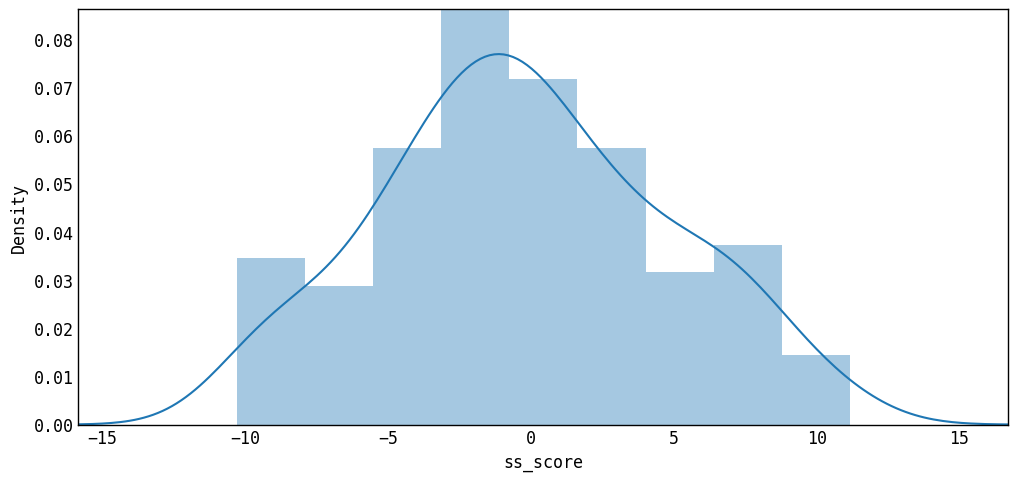

In [ ]:
residuals = y_test - y_pred
sns.distplot(residuals)

Through the above regression analysis, we can reasonably conclude that there is a relationship between sleep duration and sleep score, and that we can predict sleep score using sleep duration with reasonable accuracy.

The above setup and code for the entire process of regression analysis (exploratory data analysis, model specification, model fitting, and model evaluation) can be applied to your own data analysis of GO2SLEEP data.

